<a href="https://colab.research.google.com/github/Ahmed-Elbagoury/my_transformers/blob/main/my_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# PyTorch
import torch
import math
import torch.nn.functional as F
import torch.nn as nn
import copy
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl

# Scaled Dot Product

In [3]:
# TODO: Your implementation goes in here
def scaled_dot_product(q, k, v, mask=None):
  attn_logits = q @ k.transpose(-2, -1) / math.sqrt(q.shape[-1])
  if mask is not None:
    attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
  att = F.softmax(attn_logits, dim=-1)
  values = att @ v
  return values, att

In [4]:
# TODO: do not change this.
# It's copied from https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.ipynb
def ref_scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [5]:
# Test cases are from https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.ipynb
seq_len, d_k = 3, 2
pl.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)

ref_values, ref_attention = ref_scaled_dot_product(q, k, v)
values, attention = scaled_dot_product(q, k, v)

assert torch.allclose(ref_values, values)
assert torch.allclose(ref_attention, attention)

INFO:lightning_fabric.utilities.seed:Seed set to 42


# Multihead Attention

In [6]:
# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def ref_expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [7]:
class ref_MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = ref_expand_mask(mask)
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

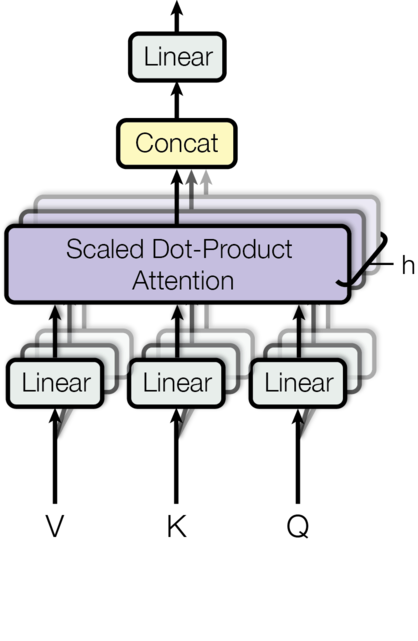

In [8]:
class MultiheadAttention(nn.Module):
  def __init__(self, input_dim, embed_dim, num_heads):
    super().__init__()
    assert embed_dim % num_heads == 0
    self.head_dim = embed_dim // num_heads
    self.num_heads = num_heads
    # qs, ks and vs for all heads
    self.qkv_proj = nn.Linear(input_dim, embed_dim * 3)
  def forward(self, x):
    batch_size, seq_len = x.shape[0], x.shape[1]
    qkv = self.qkv_proj(x) # b * seq_len * embed_dim * 3
                           # embed_dim = num_heads * head_dim
    qkv = qkv.reshape(batch_size, seq_len, self.num_heads, 3 * self.head_dim)
    qkv = qkv.permute(0, 2, 1, 3)
    qs, ks, vs = qkv.chunk(3, dim=-1)
    o, attn = scaled_dot_product(ks, qs, vs)
    o = o.reshape(batch_size, seq_len, self.head_dim * self.num_heads)
    return o, attn

In [9]:
pl.seed_everything(42)
x = torch.randn(2, 6, 32) # Batch * seq_len input_dim

INFO:lightning_fabric.utilities.seed:Seed set to 42


In [10]:
pl.seed_everything(42)
ref_mha = ref_MultiheadAttention(input_dim=32, embed_dim=8, num_heads=4)
ref_out, ref_attn = ref_mha(x, return_attention=True)
print(ref_out.shape, ref_attn.shape)

INFO:lightning_fabric.utilities.seed:Seed set to 42


torch.Size([2, 6, 8]) torch.Size([2, 4, 6, 6])


In [11]:
pl.seed_everything(42)
mha = MultiheadAttention(input_dim=32, embed_dim=8, num_heads=4)
out, att = mha(x)
print(out.shape, att.shape)

INFO:lightning_fabric.utilities.seed:Seed set to 42


torch.Size([2, 6, 8]) torch.Size([2, 4, 6, 6])


# Why reshape then permute? Why not permute to the target dimension directly

The two operations (reshape then permute v.s. permute to the target shape directly) do not give the same result. See the example below

The projection is done using a randomly initialized projection matrix. So at first glance I thought that even if the reshape the permute v.s. permute would give different resutls that should be fine as both are projection using randomly initialized weights. However, this is not true as the first two dimensions are batch dimensions. So this would produce the embeddings for one element as the concatenation across different examples across different heads. Which is not the desired behavior.

In [12]:
t = torch.range(1, 24)

<ipython-input-12-543a1154c240>:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  t = torch.range(1, 24)


In [13]:
print('Original\n', t)
t2 = t.reshape(2, 3, 4)
print('After reshaep\n', t2)
t3 = t2.permute(0, 2, 1)
print('After permute\n', t3)

t4 = t.reshape(2, 4, 3)
print('Reshape directly\n', t4)

Original
 tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])
After reshaep
 tensor([[[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.]],

        [[13., 14., 15., 16.],
         [17., 18., 19., 20.],
         [21., 22., 23., 24.]]])
After permute
 tensor([[[ 1.,  5.,  9.],
         [ 2.,  6., 10.],
         [ 3.,  7., 11.],
         [ 4.,  8., 12.]],

        [[13., 17., 21.],
         [14., 18., 22.],
         [15., 19., 23.],
         [16., 20., 24.]]])
Reshape directly
 tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.],
         [10., 11., 12.]],

        [[13., 14., 15.],
         [16., 17., 18.],
         [19., 20., 21.],
         [22., 23., 24.]]])


In [14]:
t5 = t2.permute(1, 0, 2)
print('After another permute\n', t5)

After another permute
 tensor([[[ 1.,  2.,  3.,  4.],
         [13., 14., 15., 16.]],

        [[ 5.,  6.,  7.,  8.],
         [17., 18., 19., 20.]],

        [[ 9., 10., 11., 12.],
         [21., 22., 23., 24.]]])


# Encoder Block

In [32]:
class RefEncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = ref_MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

In [33]:
refEncoderBlock = RefEncoderBlock(input_dim=32, num_heads=4, dim_feedforward=256)
pl.seed_everything(42)
x = torch.randn(2, 6, 32) # Batch * seq_len input_dim
encoded = refEncoderBlock(x)

INFO:lightning_fabric.utilities.seed:Seed set to 42
